## 7. Gaussian Mixture Model (GMM)

In [ ]:
!pip install pyod
!pip install combo

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.8/163.8 kB 3.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyod: filename=pyod-2.0.1-py3-none-any.whl size=193258 sha256=6c50be02855246cec9bb6c4f5d420f733eceb5ddbd4d557bc742ae42be4dc44e
  Stored in directory: /root/.cache/pip/wheels/94/75/88/b853cf33b0053b0a001dca55b74d515048b7656e736364eb57
Successfully built pyod
  Preparing metadata (setup.py) ... done
  Created wheel for combo: filename=combo-0.1.3-py3-none-any.whl size=42856 sha256=8ce69305b2268976886f1d2d1e73fcbe34687fe6fef143b9b464f07ad2039176
  Stored in directory: /root/.cache/pip/wheels/7a/48/ff/0d6e1017d8bf3d844d332736fbb268dca767162779f93ff50a
Successfully built combo


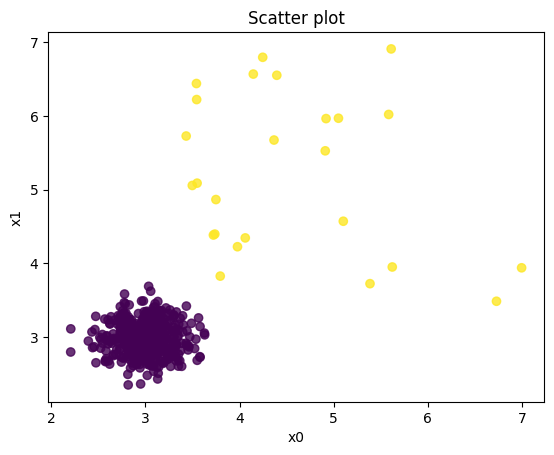

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pyod.utils.data import generate_data
contamination = 0.05 # percentage of outliers
n_train = 500       # number of training points
n_test = 500        # number of testing points
n_features = 6      # number of features
X_train, X_test, y_train, y_test = generate_data(
    n_train=n_train,
    n_test=n_test,
    n_features= n_features,
    contamination=contamination,
    random_state=123)

X_train = 5 - X_train
X_test = 5 - X_test
X_train_pd = pd.DataFrame(X_train)
X_test_pd = pd.DataFrame(X_test)
X_train_pd.head()

# Plot
plt.scatter(X_train_pd[0], X_train_pd[1], c=y_train, alpha=0.8)
plt.title('Scatter plot')
plt.xlabel('x0')
plt.ylabel('x1')
plt.show()

In [ ]:
##################################
# User-defined utility functions #
##################################

def count_stat(vector):
    # Because it is '0' and '1',
    # we can run a count statistic.
    unique, counts = np.unique(vector, return_counts=True)
    return dict(zip(unique, counts))

def descriptive_stat_threshold(df,pred_score, threshold):
    # Let's see how many '0's and '1's.
    df = pd.DataFrame(df)
    df.columns = feature_list
    df['Anomaly_Score'] = pred_score
    df['Group'] = np.where(df['Anomaly_Score']< threshold, 'Normal', 'Outlier')

    # Now let's show the summary statistics:
    cnt = df.groupby('Group')['Anomaly_Score'].count().reset_index().rename(columns={'Anomaly_Score':'Count'})
    cnt['Count %'] = (cnt['Count'] / cnt['Count'].sum()) * 100 # The count and count %
    stat = df.groupby('Group').mean().round(2).reset_index() # The avg.
    stat = cnt.merge(stat, left_on='Group',right_on='Group') # Put the count and the avg. together
    return (stat)

def confusion_matrix_threshold(
    actual,score, threshold):
    Actual_pred = pd.DataFrame({'Actual': actual, 'Pred': score})
    Actual_pred['Pred'] = np.where(Actual_pred['Pred']<=threshold,0,1)
    cm = pd.crosstab(Actual_pred['Actual'],Actual_pred['Pred'])
    return (cm)

def confusion_matrix(actual,pred):
    Actual_pred = pd.DataFrame({'Actual': actual,'Pred': pred})
    cm = pd.crosstab(Actual_pred['Actual'],Actual_pred['Pred'])
    return (cm)

def plot_data():
    plt.scatter(X_train_pd[0], X_train_pd[1],c=y_train, alpha=0.8)
    plt.title('Scatter plot')
    plt.xlabel('x0')
    plt.ylabel('x1')
    plt.show()

### Step 1: Build the model

In [ ]:
from pyod.models.gmm import GMM
gmm = GMM(n_components=4, contamination=0.05)
gmm.fit(X_train)

# Training data
y_train_scores = gmm.decision_function(X_train)
y_train_pred = gmm.predict(X_train)

# Test data
y_test_scores = gmm.decision_function(X_test)
y_test_pred = gmm.predict(X_test) # outlier labels (0 or 1)

def count_stat(vector):
    # Because it is '0' and '1', we can run a count statistic.
    unique, counts = np.unique(vector, return_counts=True)
    return dict(zip(unique, counts))

print("The training data:", count_stat(y_train_pred))
print("The training data:", count_stat(y_test_pred))
# Threshold for the defined comtanimation rate
print("The threshold for the defined contamination rate:" , gmm.threshold_)

The training data: {0: 475, 1: 25}
The training data: {0: 472, 1: 28}
The threshold for the defined contamination rate: 6.911173206263855


In [ ]:
gmm.get_params()

{'contamination': 0.05,
 'covariance_type': 'full',
 'init_params': 'kmeans',
 'max_iter': 100,
 'means_init': None,
 'n_components': 4,
 'n_init': 1,
 'precisions_init': None,
 'random_state': None,
 'reg_covar': 1e-06,
 'tol': 0.001,
 'warm_start': False,
 'weights_init': None}

### Step 2: Determine the threshold

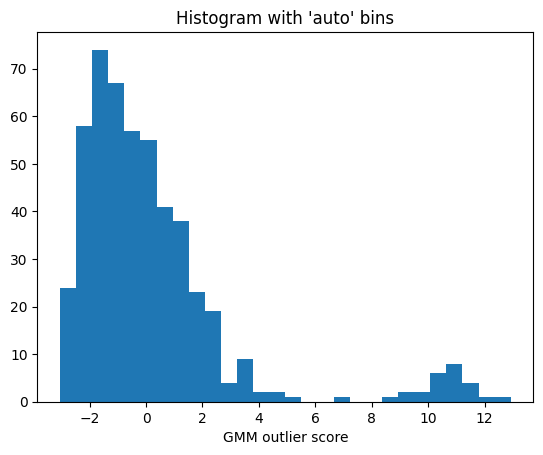

In [ ]:
import matplotlib.pyplot as plt
plt.hist(y_train_scores, bins='auto')  # arguments are passed to np.histogram
plt.title("Histogram with 'auto' bins")
plt.xlabel('GMM outlier score')
plt.show()

### Step 3: Descriptive statistics

In [ ]:
threshold = gmm.threshold_ # Or other value from the above histogram
feature_list = ['Feature_1','Feature_2','Feature_3','Feature_4','Feature_5','Feature_6']
descriptive_stat_threshold(X_train,y_train_scores, threshold)

,Group,Count,Count %,Feature_1,Feature_2,Feature_3,Feature_4,Feature_5,Feature_6,Anomaly_Score
0,Normal,475,95.0,3.00,2.99,2.99,3.01,2.99,3.02,-0.36
1,Outlier,25,5.0,4.55,5.21,5.47,5.23,5.03,5.06,10.69


In [ ]:
confusion_matrix_threshold(y_test, y_test_scores, gmm.threshold_)

Pred,0,1
Actual,,
0.0,472,3
1.0,0,25


In [ ]:
Actual_pred = pd.DataFrame({'Actual': y_test, 'Anomaly_Score': y_test_scores})
Actual_pred['Pred'] = np.where(Actual_pred['Anomaly_Score']< threshold,0,1)
pd.crosstab(Actual_pred['Actual'],Actual_pred['Pred'])

Pred,0,1
Actual,,
0.0,472,3
1.0,0,25


### Averages

In [ ]:
from pyod.models.combination import aom, moa, average, maximization
from pyod.utils.utility import standardizer
from pyod.models.gmm import GMM

# Test a range of clusters from 2 to 8. There will be 7 models.
n_clf = 7
k_list = [2, 3, 4, 5, 6, 7, 8]
n_clf = len(k_list)
# Just prepare data frames so we can store the model results
train_scores = np.zeros([X_train.shape[0], n_clf])
test_scores = np.zeros([X_test.shape[0], n_clf])

# Modeling
for i in range(n_clf):
    k = k_list[i]
    gmm = GMM(n_components = k, contamination=0.05)
    gmm.fit(X_train)
    # Store the results in each column:
    train_scores[:, i] = gmm.decision_function(X_train)
    test_scores[:, i] = gmm.decision_function(X_test)

# Decision scores have to be normalized before combination
train_scores_norm, test_scores_norm = standardizer(train_scores,test_scores)

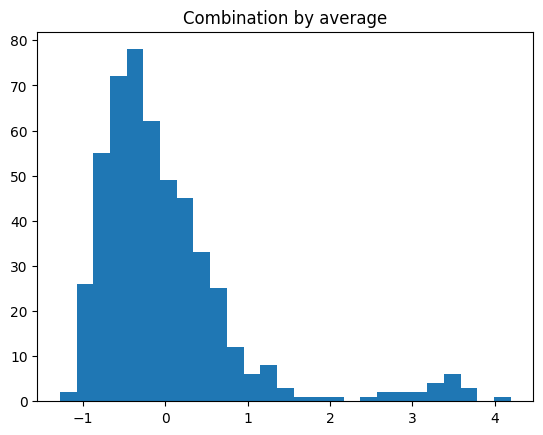

In [ ]:
# Combination by average
# The test_scores_norm is 500 x 7. The "average" function will take the average of the 7 columns.
# The result "y_by_average" is a single column:
y_train_by_average = average(train_scores_norm)
y_test_by_average = average(test_scores_norm)
import matplotlib.pyplot as plt
plt.hist(y_train_by_average, bins='auto') # arguments are passed to np.histogram
plt.title("Combination by average")
plt.show()

In [ ]:
descriptive_stat_threshold(X_train,y_train_by_average, 2.0)

,Group,Count,Count %,Feature_1,Feature_2,Feature_3,Feature_4,Feature_5,Feature_6,Anomaly_Score
0,Normal,478,95.6,3.02,3.00,3.01,3.02,3.01,3.02,-0.15
1,Outlier,22,4.4,4.20,5.25,5.45,5.25,4.82,5.20,3.24


In [ ]:
descriptive_stat_threshold(X_test,y_test_by_average, 2.0)

,Group,Count,Count %,Feature_1,Feature_2,Feature_3,Feature_4,Feature_5,Feature_6,Anomaly_Score
0,Normal,471,94.2,2.99,2.99,2.99,3.01,2.99,3.00,-0.11
1,Outlier,29,5.8,4.70,5.18,4.90,4.73,4.79,4.63,6.25
